<a href="https://colab.research.google.com/github/square-1111/RBCCPS_Assignment/blob/master/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Autoencoder
Dataset : CIFAR 10


## Imports

In [ ]:
%matplotlib inline

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt 

import keras
from keras.datasets import cifar10
from keras.layers import Conv2D,Conv2DTranspose, BatchNormalization
from keras.layers import LeakyReLU, add, Input, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model

from IPython import display

## Loading/Processing Data
To know more about the data visit [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [ ]:
(cifar_train, _), (cifar_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
# Data Specs
train_sample, length, breath, channels = cifar_train.shape

## Utils

### Normalization

In [ ]:
cifar_train = cifar_train/255.0
cifar_test  = cifar_test/255.0 

### Add Noise
$$mean\; =\; 0$$
$$std\; = \;0.3$$

In [ ]:
noise_percent = 0.3
cifar_train_noise  = cifar_train + noise_percent * \
                    np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise   = cifar_test + noise_percent * \
                    np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise  = np.clip(cifar_test_noise, 0, 1)

### Plot Image

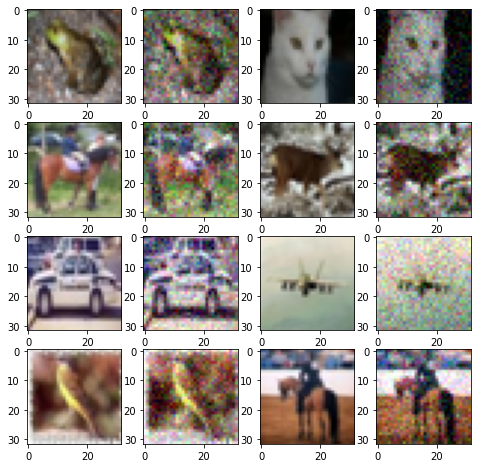

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows//2 + 1):
  index = np.random.randint(0, len(cifar_train))
  fig.add_subplot(rows, columns, 2*i-1)
  plt.imshow(cifar_train[index])
  fig.add_subplot(rows, columns, 2*i)
  plt.imshow(cifar_train_noise[index])
plt.show()

## Architecture of Autoencoder

In [ ]:
def autoencoder():
  inputs = Input(shape=(length, breath, channels))
  x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
  x = BatchNormalization()(x)
  x = MaxPool2D()(x)
  x = Dropout(0.5)(x)
  skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
  x = LeakyReLU()(skip)
  x = BatchNormalization()(x)
  x = MaxPool2D()(x)
  x = Dropout(0.5)(x)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  encoded = MaxPool2D()(x)

  x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Conv2DTranspose(32, 3, padding='same')(x)
  x = add([x,skip]) # adding skip connection
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)
  decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)
  return Model(inputs, decoded)

In [ ]:
autoencoder_net = autoencoder()
autoencoder_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

#### Plot Model

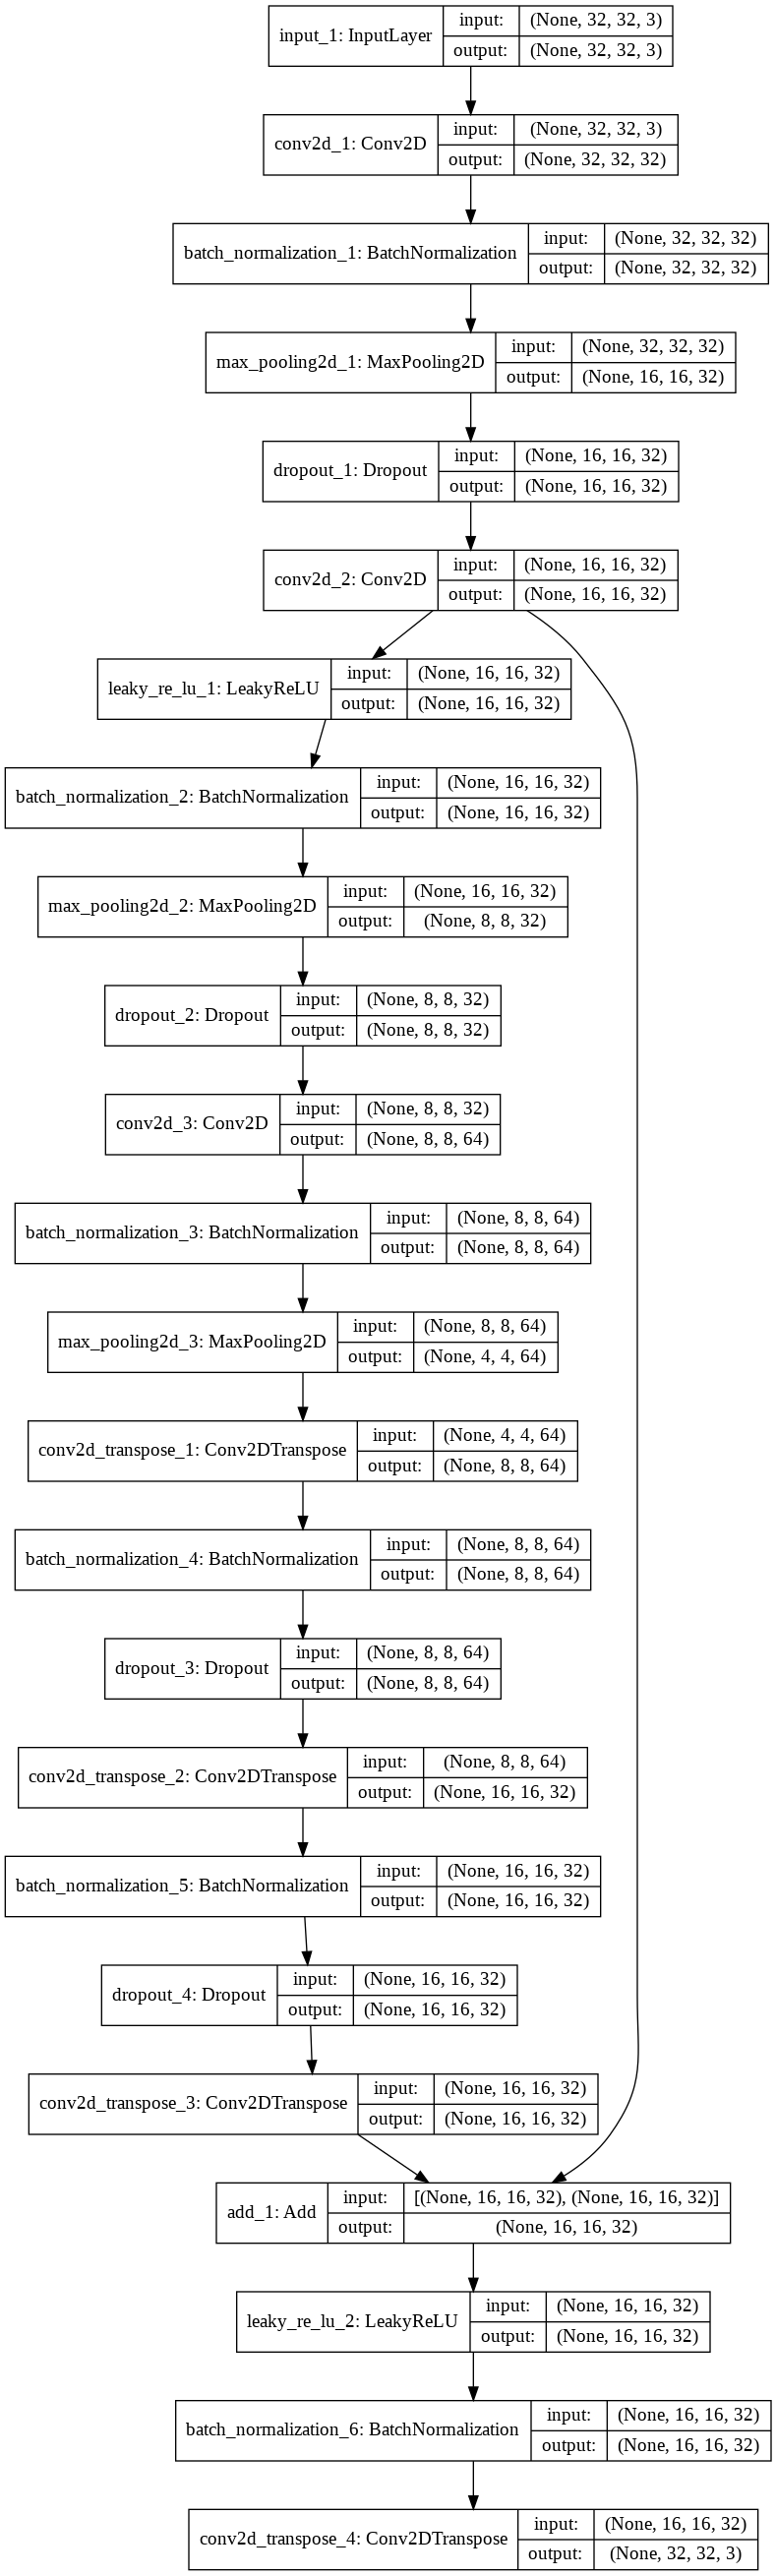

In [ ]:
plot_model(autoencoder_net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Model Parameterization and Compilation


In [ ]:
autoencoder_net.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')

In [ ]:
autoencoder = Autoencoder().to(device)
autoencoder.apply(weights_init)
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Sigmoid()
  )
)

## Parameters

In [ ]:
# Using Binary Cross Entropy Loss
criterion = nn.BCELoss().to(device)

# Using Adam Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), 
                             lr=0.0001,
                             weight_decay=1e-5)

# Number of Epochs
n_epochs = 100

# List of loss
auto_loss = []

## Train Model

In [ ]:
# Training
epochs = 25
batch_size = 256

history = autoencoder_net.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test)
               )

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 24s 477us/step - loss: 0.5787 - val_loss: 0.6175
Epoch 2/25
50000/50000 [==============================] - 17s 330us/step - loss: 0.5616 - val_loss: 0.5749
Epoch 3/25
50000/50000 [==============================] - 17s 331us/step - loss: 0.5599 - val_loss: 0.5608
Epoch 4/25
50000/50000 [==============================] - 17s 330us/step - loss: 0.5591 - val_loss: 0.5581
Epoch 5/25
50000/50000 [==============================] - 16s 328us/step - loss: 0.5585 - val_loss: 0.5568
Epoch 6/25
50000/50000 [==============================] - 16s 329us/step - loss: 0.5581 - val_loss: 0.5560
Epoch 7/25
50000/50000 [==============================] - 16s 328us/step - loss: 0.5579 - val_loss: 0.5558
Epoch 8/25
50000/50000 [==============================] - 16s 327us/step - loss: 0.5577 - val_loss: 0.5554
Epoch 9/25
50000/50000 [==============================] - 16s 325us/step - loss: 0.5576 - val_

#### Plotting Loss

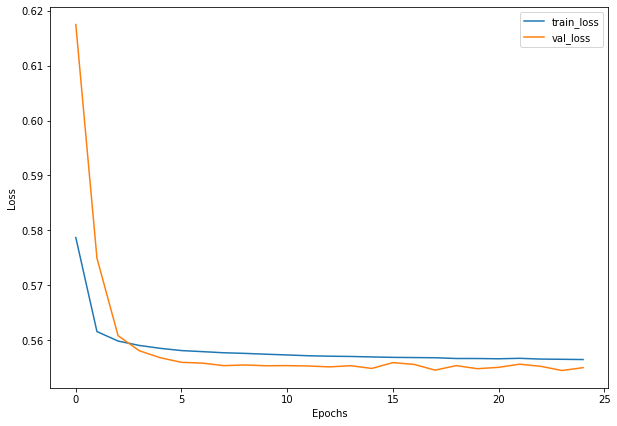

In [ ]:
# Define Loss
f = plt.figure(figsize=(10,7))
f.add_subplot()

# Adding Subplot
# Loss curve for training set
plt.plot(history.epoch, history.history['loss'], label = "train_loss") 
# Loss curve for validation set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") 

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

## Testing

In [ ]:
## Randomly select 9 samples
sample_index = np.random.randint(0, len(cifar_test), size=(9))
sample_clean_img = cifar_test[sample_index]
sample_noisy_img = cifar_test_noise[sample_index]

#### Denoise : Autoencoder Prediction

In [ ]:
denoised_imgs = autoencoder_net.predict(sample_noisy_img)

#### Plot Images

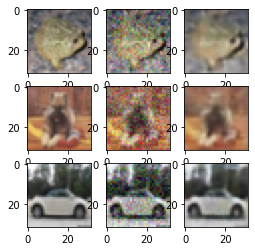

In [ ]:
fig=plt.figure(figsize=(4, 4))
columns = 3
rows = 3
for i in range(1, columns*rows//3 + 1):
  fig.add_subplot(rows, columns, 3*i-2)
  plt.imshow(sample_clean_img[i])
  fig.add_subplot(rows, columns, 3*i-1)
  plt.imshow(sample_noisy_img[i])
  fig.add_subplot(rows, columns, 3*i)
  plt.imshow(denoised_imgs[i])
plt.show()